In [1]:
!python --version

Python 3.10.12


In [4]:
#Always activate the environment before running this notebook!
#cd /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project
#source venv/bin/activate

We are importing all the necessary libraries.

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data preparation

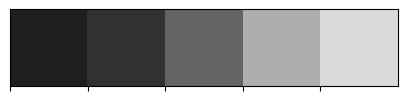

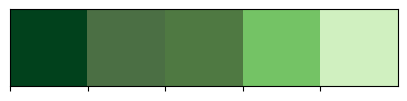

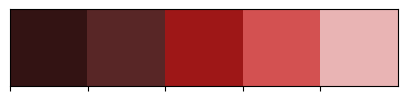

In [41]:
#Color definition for images
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [42]:
#Introducing labels in the dataset

dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

Loading training dataset

In [43]:
# Initialize lists
X_train = []
y_train = []
image_size = 150  # Resize all images to 150x150

# Load training images
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)  # Read the image
        if img is not None:  # Ensure image is loaded correctly
            img = cv2.resize(img, (image_size, image_size))  # Resize
            X_train.append(img)
            y_train.append(label)  # Store the label as a string

# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Loaded {X_train.shape[0]} images from the Training dataset.")

Loading pituitary_tumor: 100%|██████████| 827/827 [00:00<00:00, 1059.47it/s]


Loaded 2870 images from the Training dataset.


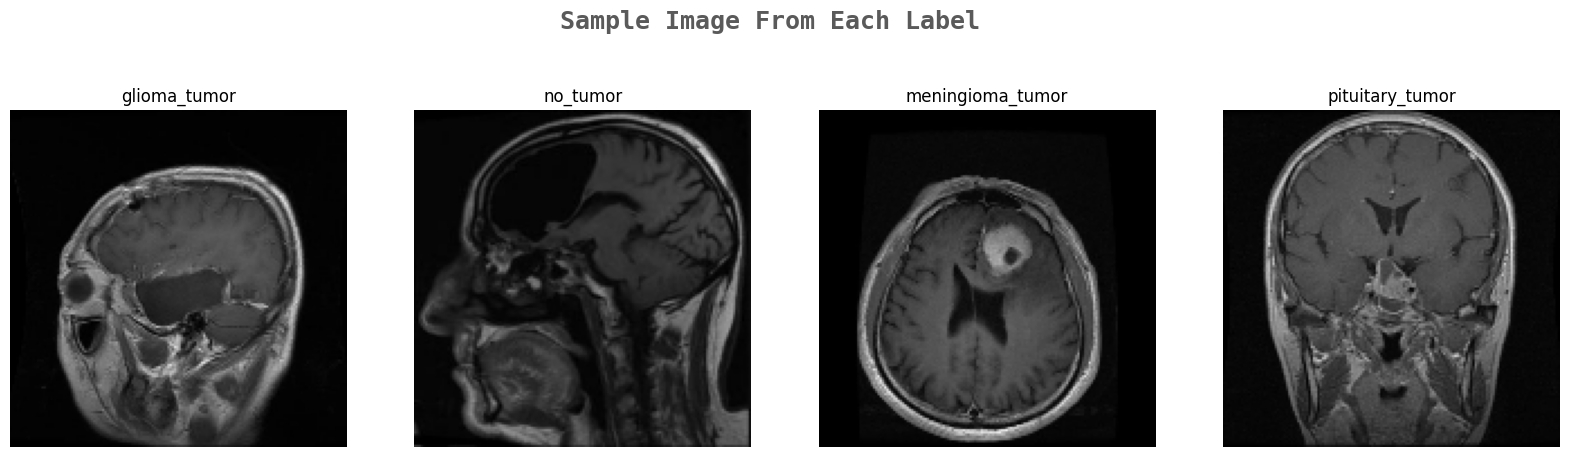

In [44]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [45]:
#Format test
print("Image shape:", X_train[0].shape)
print("Image data type:", X_train[0].dtype)


Image shape: (150, 150, 3)
Image data type: uint8


Convert BRG images into RGB

In [46]:
X_train = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_train]


Data augmentation for no_tumor

In [47]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
no_tumor_dir = os.path.join(train_dir, "no_tumor")
augmented_dir = os.path.join(train_dir, "no_tumor_augmented")

# Ensure the augmented directory exists
os.makedirs(augmented_dir, exist_ok=True)

# Augmentation settings
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.90, 1.10],
    width_shift_range=0.05,
    height_shift_range=0.05
)

# Use previously loaded no_tumor images
num_augmented = 425  # Target number of augmented images
count = 0

X_train = np.array(X_train)  # Ensure NumPy array
mask = np.array(y_train) == 'no_tumor'
X_no_tumor = X_train[mask]
for img in tqdm(X_no_tumor, desc="Generating augmented images"):
    img = np.expand_dims(img, axis=0)  # Reshape for ImageDataGenerator
    aug_iter = datagen.flow(img, batch_size=1)
    
    for _ in range(2):  # Generate 2 new images per original
        aug_img = next(aug_iter)[0].astype(np.uint8)  # Convert back to uint8
        save_path = os.path.join(augmented_dir, f"aug_{count}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))  # Save as BGR
        count += 1
        
        if count >= num_augmented:
            break
    
    if count >= num_augmented:
        break

print(f"Generated {count} augmented images in {augmented_dir}")

Generating augmented images:  54%|█████▎    | 212/395 [00:01<00:01, 178.77it/s]

Generated 425 augmented images in /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented


Check if augmented images look decent

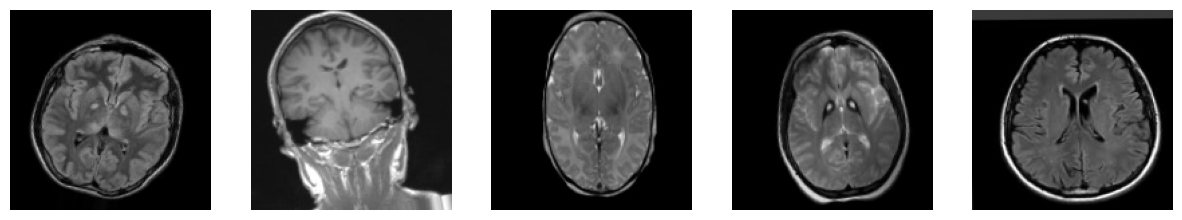

In [48]:
import matplotlib.pyplot as plt
import random
import cv2
import os

# Path to augmented images
augmented_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented"

# Get a list of augmented image files
augmented_files = os.listdir(augmented_dir)
random.shuffle(augmented_files)  # Shuffle to pick random images

# Display 5 random images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    img_path = os.path.join(augmented_dir, augmented_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for correct display
    ax.imshow(img)
    ax.axis('off')

plt.show()


Integrate augmented data to training set

In [49]:
# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_dir = os.path.join(train_dir, "no_tumor_augmented")

# Load augmented images
augmented_images = []
augmented_labels = []

for filename in os.listdir(augmented_dir):
    img_path = os.path.join(augmented_dir, filename)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for consistency
        augmented_images.append(img)
        augmented_labels.append('no_tumor')  # Assign correct label

# Convert to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Append to training dataset
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

print(f"Final dataset size after augmentation: {X_train.shape[0]} images")

Final dataset size after augmentation: 3295 images


Confirming class distribution after augmentation

In [50]:
import os
from collections import Counter

# Define training directory
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"

# Define class subfolders
classes = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor_augmented"]

# Count images in each class
class_counts = {}

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.exists(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Merge 'no_tumor' and 'no_tumor_augmented'
if "no_tumor_augmented" in class_counts:
    class_counts["no_tumor"] += class_counts.pop("no_tumor_augmented")

# Print class distribution
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")


glioma_tumor: 826 images
no_tumor: 820 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


Data preprocessing

In [51]:
#One-hot encoding of labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode class labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert to 0,1,2,3

# One-hot encode labels
y_train_one_hot = to_categorical(y_train_encoded, num_classes=4)

# Print class mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Encoding Mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [52]:
print(f"X_train shape: {X_train.shape}")  # Should be (N, 224, 224, 3)
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")  # Should be (N, 4)


X_train shape: (3295, 150, 150, 3)
y_train_one_hot shape: (3295, 4)


Build the model building up on EfficientNetB0

In [64]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall

# Define input layer (match dataset size)
input_layer = Input(shape=(150, 150, 3), name="input_layer")

# Load EfficientNetB0 WITH ImageNet weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Pass input manually
x = base_model(input_layer)

# Freeze base model layers
base_model.trainable = False  

# Add classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Create final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])

# Model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training

In [65]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# 1️⃣ TensorBoard - Logs training details
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# 2️⃣ ModelCheckpoint - Saves the best model
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.h5",  # Save the best model
    monitor="val_loss",        # Track validation loss
    save_best_only=True,       # Save only when the model improves
    verbose=1
)

# 3️⃣ ReduceLROnPlateau - Adjusts learning rate when training stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",        # Watch validation loss
    factor=0.1,                # Reduce LR by 10x
    patience=3,                # Wait 3 epochs before reducing LR
    min_lr=1e-6,               # Do not reduce LR below this value
    verbose=1
)

# 📌 Combine all callbacks
callbacks = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]


Split training dataset into training and validation

In [66]:
from sklearn.model_selection import train_test_split

# Convert one-hot labels to class labels for stratified splitting
y_train_labels = np.argmax(y_train_one_hot, axis=1)

# Split the dataset (80% train, 20% validation)
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(
    X_train, y_train_labels, test_size=0.2, random_state=42, stratify=y_train_labels
)

# Convert back to one-hot encoding
y_train_balanced_one_hot = tf.keras.utils.to_categorical(y_train_balanced, num_classes=4)
y_val_balanced_one_hot = tf.keras.utils.to_categorical(y_val_balanced, num_classes=4)

# Print shapes and validation distribution
print(f"Balanced Training set: {X_train_balanced.shape}, {y_train_balanced_one_hot.shape}")
print(f"Balanced Validation set: {X_val_balanced.shape}, {y_val_balanced_one_hot.shape}")

# Check the class distribution in the balanced validation set
unique, counts = np.unique(y_val_balanced, return_counts=True)
print("Balanced Validation Set Class Distribution:", dict(zip(unique, counts)))


Balanced Training set: (2636, 150, 150, 3), (2636, 4)
Balanced Validation set: (659, 150, 150, 3), (659, 4)
Balanced Validation Set Class Distribution: {0: 165, 1: 164, 2: 164, 3: 166}


Training model

In [ ]:
# Train the model with balanced datasets
history = model.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5472 - loss: 1.0839 - precision: 0.5920 - recall: 0.4611
Epoch 1: val_loss improved from inf to 0.47126, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - accuracy: 0.5486 - loss: 1.0813 - precision: 0.5934 - recall: 0.4629 - val_accuracy: 0.8194 - val_loss: 0.4713 - val_precision: 0.8394 - val_recall: 0.8012 - learning_rate: 0.0010
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7745 - loss: 0.5844 - precision: 0.7938 - recall: 0.7497
Epoch 2: val_loss did not improve from 0.47126
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.7746 - loss: 0.5844 - precision: 0.7939 - recall: 0.7498 - val_accuracy: 0.8437 - val_loss: 0.4979 - val_precision: 0.8596 - val_recall: 0.8179 - learning_rate: 0.0010
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8183 - loss: 0.5051 - precision: 0.8418 - recall: 0.8045
Epoch 3: val_loss improved from 0.47126 to 0.41631, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8183 - loss: 0.5051 - precision: 0.8417 - recall: 0.8044 - val_accuracy: 0.8528 - val_loss: 0.4163 - val_precision: 0.8722 - val_recall: 0.8392 - learning_rate: 0.0010
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8361 - loss: 0.4598 - precision: 0.8538 - recall: 0.8191
Epoch 4: val_loss improved from 0.41631 to 0.37425, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8360 - loss: 0.4596 - precision: 0.8537 - recall: 0.8191 - val_accuracy: 0.8649 - val_loss: 0.3743 - val_precision: 0.8797 - val_recall: 0.8543 - learning_rate: 0.0010
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8523 - loss: 0.3859 - precision: 0.8613 - recall: 0.8430
Epoch 5: val_loss did not improve from 0.37425
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8524 - loss: 0.3859 - precision: 0.8614 - recall: 0.8430 - val_accuracy: 0.8695 - val_loss: 0.3896 - val_precision: 0.8783 - val_recall: 0.8543 - learning_rate: 0.0010
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8643 - loss: 0.3538 - precision: 0.8719 - recall: 0.8486
Epoch 6: val_loss improved from 0.37425 to 0.35029, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8642 - loss: 0.3539 - precision: 0.8719 - recall: 0.8486 - val_accuracy: 0.8771 - val_loss: 0.3503 - val_precision: 0.8868 - val_recall: 0.8680 - learning_rate: 0.0010
Epoch 7/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8883 - loss: 0.2973 - precision: 0.8952 - recall: 0.8754
Epoch 7: val_loss did not improve from 0.35029
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8880 - loss: 0.2979 - precision: 0.8949 - recall: 0.8751 - val_accuracy: 0.8649 - val_loss: 0.3851 - val_precision: 0.8758 - val_recall: 0.8558 - learning_rate: 0.0010
Epoch 8/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8728 - loss: 0.3310 - precision: 0.8874 - recall: 0.8628
Epoch 8: val_loss improved from 0.35029 to 0.32732, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8729 - loss: 0.3307 - precision: 0.8875 - recall: 0.8629 - val_accuracy: 0.8801 - val_loss: 0.3273 - val_precision: 0.8844 - val_recall: 0.8710 - learning_rate: 0.0010
Epoch 9/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8702 - loss: 0.3353 - precision: 0.8841 - recall: 0.8642
Epoch 9: val_loss did not improve from 0.32732
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8703 - loss: 0.3352 - precision: 0.8842 - recall: 0.8643 - val_accuracy: 0.8847 - val_loss: 0.3339 - val_precision: 0.8908 - val_recall: 0.8786 - learning_rate: 0.0010
Epoch 10/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8921 - loss: 0.2791 - precision: 0.8967 - recall: 0.8868
Epoch 10: val_loss improved from 0.32732 to 0.32311, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8921 - loss: 0.2791 - precision: 0.8968 - recall: 0.8869 - val_accuracy: 0.8725 - val_loss: 0.3231 - val_precision: 0.8825 - val_recall: 0.8665 - learning_rate: 0.0010
Epoch 11/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9061 - loss: 0.2632 - precision: 0.9152 - recall: 0.9003
Epoch 11: val_loss improved from 0.32311 to 0.31301, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9060 - loss: 0.2634 - precision: 0.9151 - recall: 0.9002 - val_accuracy: 0.8816 - val_loss: 0.3130 - val_precision: 0.8870 - val_recall: 0.8695 - learning_rate: 0.0010
Epoch 12/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9054 - loss: 0.2459 - precision: 0.9145 - recall: 0.8998
Epoch 12: val_loss did not improve from 0.31301
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9055 - loss: 0.2457 - precision: 0.9146 - recall: 0.8999 - val_accuracy: 0.8892 - val_loss: 0.3162 - val_precision: 0.8896 - val_recall: 0.8801 - learning_rate: 0.0010
Epoch 13/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9059 - loss: 0.2548 - precision: 0.9123 - recall: 0.9016
Epoch 13: val_loss improved from 0.31301 to 0.30427, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9059 - loss: 0.2548 - precision: 0.9123 - recall: 0.9016 - val_accuracy: 0.8816 - val_loss: 0.3043 - val_precision: 0.8908 - val_recall: 0.8786 - learning_rate: 0.0010
Epoch 14/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9118 - loss: 0.2447 - precision: 0.9153 - recall: 0.9031
Epoch 14: val_loss did not improve from 0.30427
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9117 - loss: 0.2447 - precision: 0.9153 - recall: 0.9031 - val_accuracy: 0.8923 - val_loss: 0.3272 - val_precision: 0.9002 - val_recall: 0.8892 - learning_rate: 0.0010
Epoch 15/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9240 - loss: 0.2063 - precision: 0.9294 - recall: 0.9212
Epoch 15: val_loss improved from 0.30427 to 0.29152, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9238 - loss: 0.2067 - precision: 0.9292 - recall: 0.9210 - val_accuracy: 0.8968 - val_loss: 0.2915 - val_precision: 0.9062 - val_recall: 0.8938 - learning_rate: 0.0010
Epoch 16/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9177 - loss: 0.2183 - precision: 0.9210 - recall: 0.9137
Epoch 16: val_loss improved from 0.29152 to 0.28313, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9176 - loss: 0.2184 - precision: 0.9210 - recall: 0.9136 - val_accuracy: 0.8983 - val_loss: 0.2831 - val_precision: 0.9048 - val_recall: 0.8938 - learning_rate: 0.0010
Epoch 17/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9141 - loss: 0.2182 - precision: 0.9196 - recall: 0.9118
Epoch 17: val_loss did not improve from 0.28313
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9140 - loss: 0.2182 - precision: 0.9196 - recall: 0.9118 - val_accuracy: 0.8801 - val_loss: 0.3268 - val_precision: 0.8846 - val_recall: 0.8725 - learning_rate: 0.0010
Epoch 18/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8980 - loss: 0.2419 - precision: 0.9022 - recall: 0.8912
Epoch 18: val_loss did not improve from 0.28313
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8983 - loss: 0.2415 - precision: 0.9026 - recall: 0.8916 - val_accuracy: 0.8938 - val_loss: 0.3267 - val_precision: 0.8989 - val_recall: 0.8907 - learning_rate:


Epoch 25: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9323 - loss: 0.1868 - precision: 0.9373 - recall: 0.9252 - val_accuracy: 0.9014 - val_loss: 0.2831 - val_precision: 0.9077 - val_recall: 0.8953 - learning_rate: 1.0000e-05
Epoch 26/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9331 - loss: 0.1858 - precision: 0.9419 - recall: 0.9314
Epoch 26: val_loss improved from 0.28309 to 0.28304, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9331 - loss: 0.1856 - precision: 0.9418 - recall: 0.9314 - val_accuracy: 0.9014 - val_loss: 0.2830 - val_precision: 0.9077 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 27/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9395 - loss: 0.1648 - precision: 0.9452 - recall: 0.9357
Epoch 27: val_loss improved from 0.28304 to 0.28298, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9395 - loss: 0.1648 - precision: 0.9452 - recall: 0.9357 - val_accuracy: 0.9014 - val_loss: 0.2830 - val_precision: 0.9077 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 28/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9276 - loss: 0.1890 - precision: 0.9301 - recall: 0.9213
Epoch 28: val_loss improved from 0.28298 to 0.28292, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9278 - loss: 0.1887 - precision: 0.9303 - recall: 0.9214 - val_accuracy: 0.9014 - val_loss: 0.2829 - val_precision: 0.9063 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 29/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9322 - loss: 0.1795 - precision: 0.9347 - recall: 0.9286
Epoch 29: val_loss did not improve from 0.28292
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9323 - loss: 0.1794 - precision: 0.9348 - recall: 0.9287 - val_accuracy: 0.8998 - val_loss: 0.2829 - val_precision: 0.9063 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 30/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9313 - loss: 0.1768 - precision: 0.9358 - recall: 0.9283
Epoch 30: val_loss did not improve from 0.28292

Epoch 30: ReduceLROnPlateau reducing learning rate to 1e-06.
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9313 - loss: 0.1767 - precision: 0.9358 - recall: 0.9283 - val_accuracy: 0.8998 - val_loss

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9341 - loss: 0.1921 - precision: 0.9361 - recall: 0.9290 - val_accuracy: 0.9014 - val_loss: 0.2829 - val_precision: 0.9077 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 32/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9298 - loss: 0.1972 - precision: 0.9329 - recall: 0.9253
Epoch 32: val_loss improved from 0.28289 to 0.28286, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9299 - loss: 0.1970 - precision: 0.9331 - recall: 0.9254 - val_accuracy: 0.9014 - val_loss: 0.2829 - val_precision: 0.9077 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 33/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9271 - loss: 0.1900 - precision: 0.9316 - recall: 0.9250
Epoch 33: val_loss improved from 0.28286 to 0.28282, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9271 - loss: 0.1899 - precision: 0.9316 - recall: 0.9250 - val_accuracy: 0.9014 - val_loss: 0.2828 - val_precision: 0.9077 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 34/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9407 - loss: 0.1871 - precision: 0.9458 - recall: 0.9368
Epoch 34: val_loss did not improve from 0.28282
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9407 - loss: 0.1868 - precision: 0.9459 - recall: 0.9368 - val_accuracy: 0.9014 - val_loss: 0.2828 - val_precision: 0.9077 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 35/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9379 - loss: 0.1906 - precision: 0.9434 - recall: 0.9325
Epoch 35: val_loss improved from 0.28282 to 0.28279, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9380 - loss: 0.1902 - precision: 0.9435 - recall: 0.9326 - val_accuracy: 0.9014 - val_loss: 0.2828 - val_precision: 0.9063 - val_recall: 0.8953 - learning_rate: 1.0000e-06
Epoch 36/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9318 - loss: 0.1658 - precision: 0.9356 - recall: 0.9254
Epoch 36: val_loss did not improve from 0.28279
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9319 - loss: 0.1659 - precision: 0.9356 - recall: 0.9254 - val_accuracy: 0.9014 - val_loss: 0.2828 - val_precision: 0.9064 - val_recall: 0.8968 - learning_rate: 1.0000e-06
Epoch 37/40
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9361 - loss: 0.1731 - precision: 0.9409 - recall: 0.9291
Epoch 37: val_loss did not improve from 0.28279
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9360 - loss: 0.1734 - precision: 0.9407 - recall: 0.9290 - val_accuracy: 0.9014 - val_loss: 0.2828 - val_precision: 0.9064 - val_recall: 0.8968 - learni

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9359 - loss: 0.1738 - precision: 0.9399 - recall: 0.9287 - val_accuracy: 0.9014 - val_loss: 0.2828 - val_precision: 0.9064 - val_recall: 0.8968 - learning_rate: 1.0000e-06
Epoch 40/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9316 - loss: 0.1812 - precision: 0.9349 - recall: 0.9265
Epoch 40: val_loss improved from 0.28277 to 0.28273, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9316 - loss: 0.1812 - precision: 0.9349 - recall: 0.9265 - val_accuracy: 0.9014 - val_loss: 0.2827 - val_precision: 0.9078 - val_recall: 0.8968 - learning_rate: 1.0000e-06


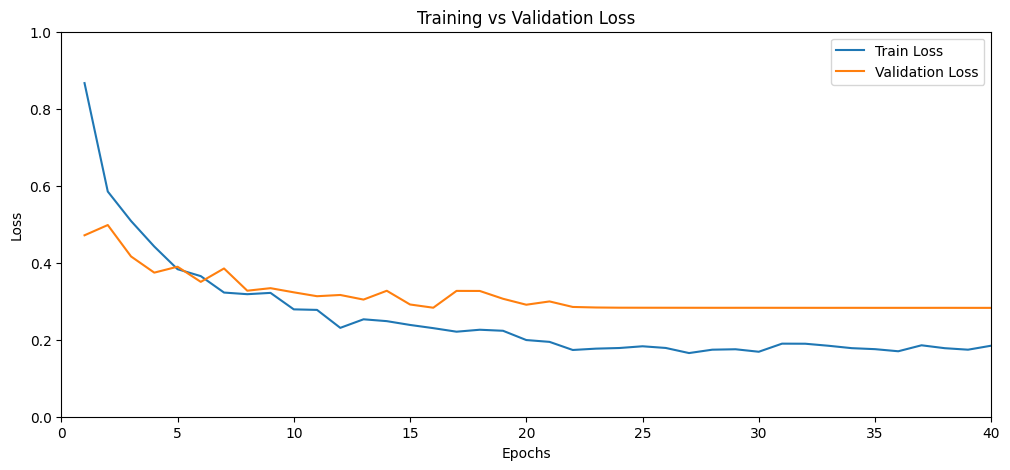

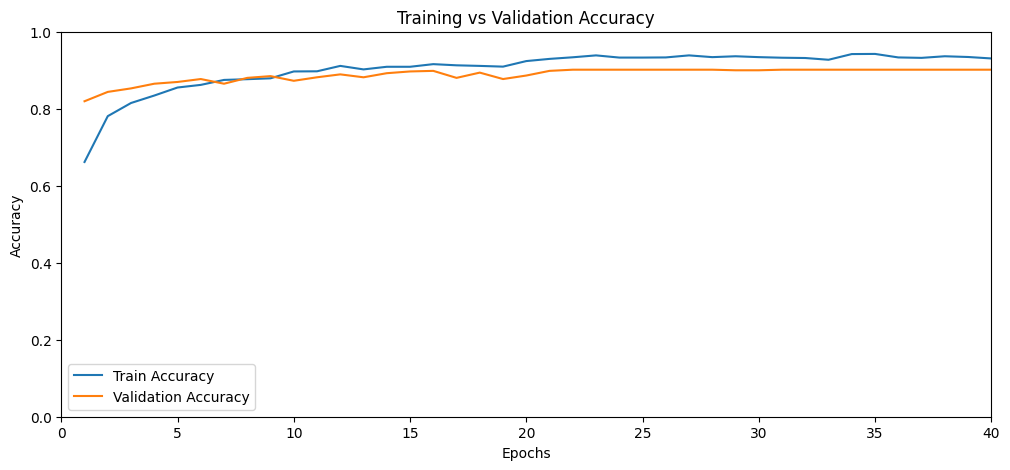

In [69]:
epochs = range(1, len(history.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history.history["loss"], label="Train Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()


# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()



In [71]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions from the model (on validation or test set)
pred = model.predict(X_val_balanced)  # Change to X_test if you want to evaluate on the test set

# Convert predictions from one-hot to class labels
pred_labels = np.argmax(pred, axis=1)

# If you want to evaluate on validation set, use y_val_balanced (or y_test for test data)
y_true_labels = np.argmax(y_val_balanced_one_hot, axis=1)

# Print classification report
print(classification_report(y_true_labels, pred_labels))


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       165
           1       0.82      0.80      0.81       164
           2       0.93      0.98      0.95       164
           3       0.93      0.97      0.95       166

    accuracy                           0.90       659
   macro avg       0.90      0.90      0.90       659
weighted avg       0.90      0.90      0.90       659



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


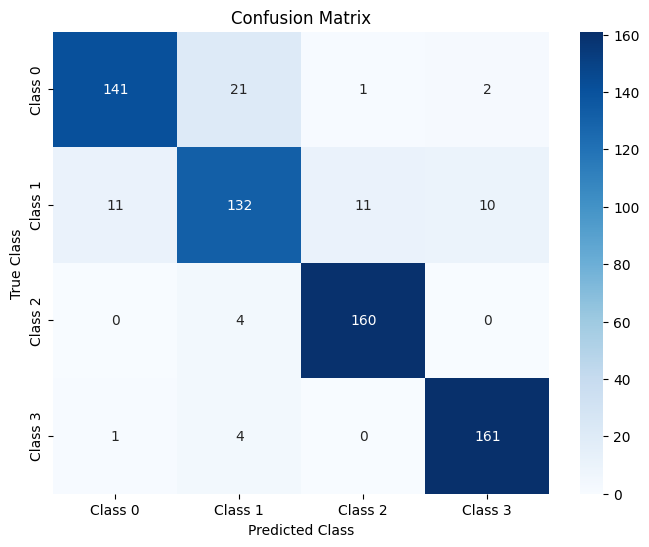

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on validation set
y_pred = model.predict(X_val_balanced)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_val_balanced_one_hot, axis=1), y_pred_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()
